# Logistic Regression (Olive Oils dataset)

In [57]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.7


## Load raw data and plot

In [58]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/olive_oils/FTIR_olive_oils.csv')
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
0,0.127523,0.127950,0.129282,0.131174,0.133590,0.136426,0.139358,0.142219,0.144805,0.146764,...,0.012279,0.012158,0.011884,0.011716,0.011583,0.011315,0.011304,1,Greece,1
1,0.126498,0.127131,0.128511,0.130340,0.132527,0.135309,0.138353,0.141150,0.143630,0.145624,...,0.006467,0.006223,0.005720,0.005518,0.005494,0.005321,0.005426,1,Greece,1
2,0.130412,0.130675,0.132017,0.133824,0.136095,0.138944,0.141723,0.144136,0.146431,0.148389,...,0.007548,0.007391,0.007176,0.006843,0.006551,0.006398,0.006582,1,Greece,2
3,0.130022,0.130407,0.132018,0.134007,0.136271,0.138875,0.141481,0.144075,0.146553,0.148443,...,0.006059,0.005933,0.005507,0.005347,0.005349,0.005133,0.005222,1,Greece,2
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3


In [59]:
# shuffle data rows
data = data.sample(frac=1)

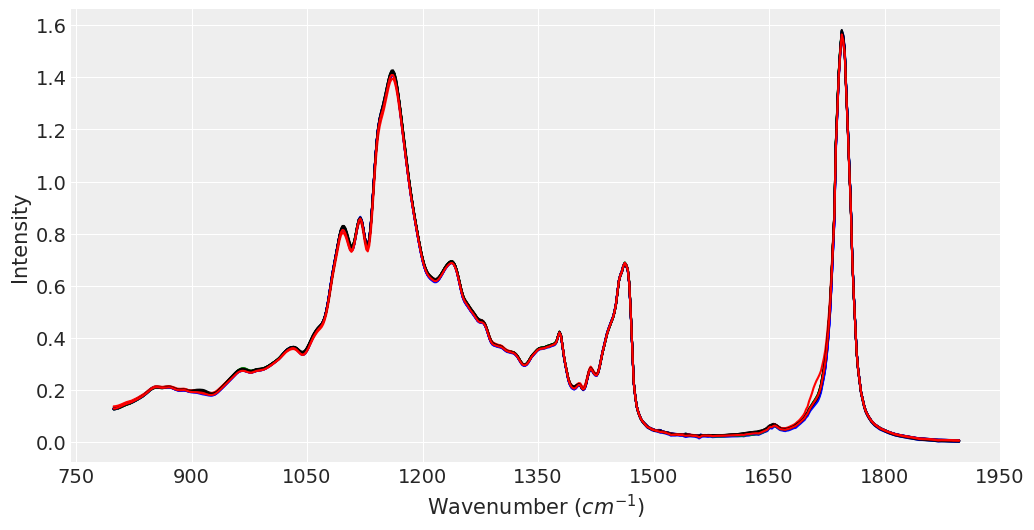

In [60]:
# number of non-data columns at right of dataframe
ndata_cols = -3

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(20):
    y_val = data.values[i]
    if y_val[-2] == 'Spain':
        col = 'blue'
    elif y_val[-2] == 'Greece':
        col = 'green'
    elif y_val[-2] == 'Portugal':
        col = 'red'
    else:
        col = 'black'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [61]:
# number of samples from each class
data['label'].value_counts()

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64

In [97]:
# generate training and test sets
train_data, test_data = train_test_split(data, train_size=0.2, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [98]:
test_data.shape

(96, 573)

In [99]:
train_data.shape

(24, 573)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = softmax(\alpha+\beta X) \\
y \sim Categorical(\theta)
\end{equation}

In [100]:
# standardize data
Y = pd.Categorical(train_data['label']).codes
x_n = train_data.columns[:ndata_cols]
x_s = train_data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(24, 570)

In [101]:
# number of classes in dataset
tclass = 4

train_data['label'].value_counts()

Spain       13
Greece       4
Italy        4
Portugal     3
Name: label, dtype: int64

In [102]:
import theano.tensor as tt

with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=1, shape=tclass)
    beta = pm.Normal('beta', mu=0, sd=1, shape=(len(x_n), tclass))
                     
    mu = pm.Deterministic('mu', alpha + pm.math.dot(x_s, beta))
                     
    theta = tt.nnet.softmax(mu)
                     
    y_pred = pm.Categorical('y_pred', p=theta, observed=Y)
                     
    trace_mlr = pm.sample(1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 3000/3000 [08:18<00:00,  6.02draws/s]


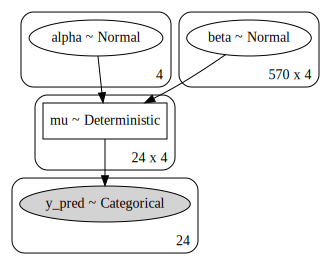

In [103]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [104]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.214,0.511,-1.220,0.705,0.017,0.012,875.0,875.0,878.0,1154.0,1.0
alpha[1],-0.212,0.514,-1.165,0.742,0.017,0.012,868.0,868.0,871.0,1229.0,1.0
alpha[2],-0.540,0.517,-1.569,0.343,0.017,0.012,895.0,895.0,897.0,1159.0,1.0
alpha[3],1.052,0.510,0.074,1.984,0.017,0.012,870.0,870.0,871.0,1144.0,1.0
"beta[0,0]",-0.009,1.021,-1.805,1.931,0.014,0.026,5217.0,768.0,5237.0,1368.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
"beta[568,3]",-0.010,1.000,-1.908,1.820,0.014,0.026,5324.0,744.0,5318.0,1550.0,1.0
"beta[569,0]",0.015,0.964,-1.730,1.892,0.014,0.023,4520.0,859.0,4522.0,1437.0,1.0
"beta[569,1]",0.002,0.985,-1.807,1.808,0.015,0.026,4567.0,726.0,4557.0,1521.0,1.0
"beta[569,2]",0.010,0.981,-1.752,1.833,0.014,0.024,4586.0,821.0,4580.0,1303.0,1.0


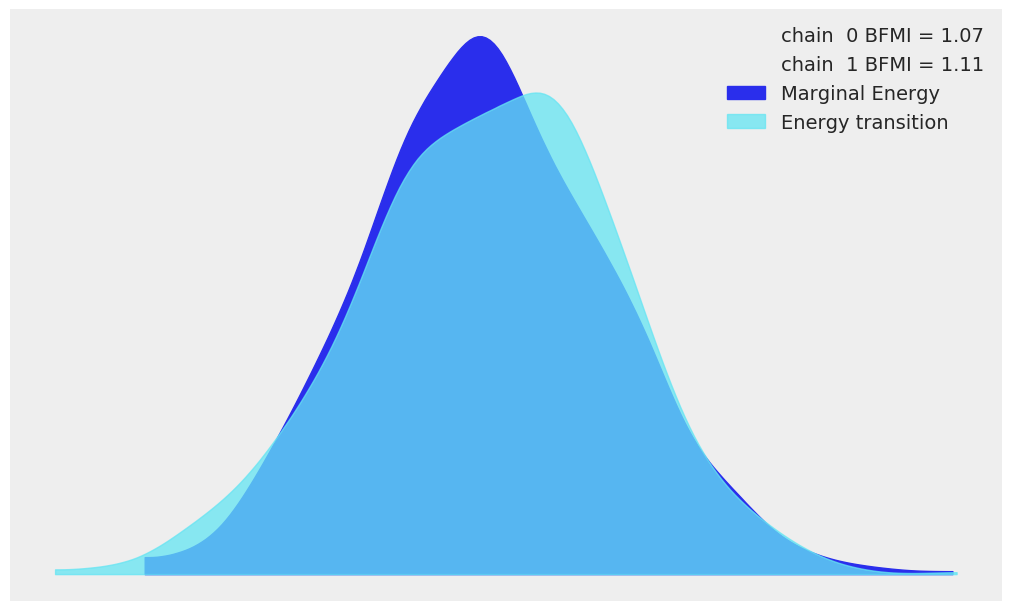

In [105]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [126]:
# correct predictions on training data
data_pred = trace_mlr['mu'].mean(0)

y_pred = [np.exp(point)/np.sum(np.exp(point), axis=0)
          for point in data_pred]

print("training size: ", len(y_pred), "samples")
cnt = 0
for i in range(len(y_pred)):
#    print(y_pred[i], Y[i], np.argmax(y_pred[i]))
    if np.argmax(y_pred[i]) == Y[i]:
        cnt +=1
print("correct label: ", cnt, "samples")

f'{cnt/len(y_pred) * 100:.1f}'

training size:  24 samples
correct label:  13 samples


'54.2'